## 2D Wavelet
### ハール離散ウェーブレット変換による画像圧縮
### Image compression using Haar discrete wavelet transform
Ref: 「やり直しのための通信数学: フーリエ変換からウェーブレット変換へ (ディジタル信号処理シリーズ)」（三谷 政昭）、CQ出版社、2008<br>
#### 規定以外のファイルを読み込ませて処理した場合にエラーがでますが、どのようなエラーなのか？、また、エラーが出ないようにするにはどうすれば良いのか？など、工夫してみましょう。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog
import os
from PIL import Image

In [2]:
def getTargetDir(dirname):
    root = tk.Tk()
    root.attributes('-topmost', True)
    root.withdraw()
    #実行中のフォルダへのパスを絶対パスで取得
    iDir = os.path.abspath(dirname) 
    #ファイルダイアログを開き、選択したファイルへの絶対パスを取得
    fType = [("ImageFile","*.png;*.jpg;*.bmp")]
    title ="画像ファイル：圧縮時に補正しないため各辺は2の「圧縮レベル乗」であること"
    target_path = filedialog.askopenfilename(filetypes=fType, initialdir=iDir,title=title)
    if target_path:
        target_name = os.path.basename(target_path)
        path_to_parent_dir = os.path.dirname(target_path)
    else:
        target_name = None
        path_to_parent_dir = None
    root.destroy()
    return target_name, path_to_parent_dir

### 外部ファイル選択
levelの数分、2の累乗で縮小するため、画像の各辺のピクセル数が1024x1024等の正確に2のlevel乗で割り切れるようにしておくこと<br>
#### アドバンスコース：<br>
わざと上記の規定に合わないファイルを入力して処理した場合、どこでどのようなエラーが出るのか？、また、エラーが出ないようにするには、どのようにすれば良いのか？等、様々に工夫・改良するなどしてみましょう。<br>

In [3]:
fName, PName = getTargetDir(os.getcwd())

### 外部ファイル未選択時、sample imageをセット
外部ファイルを取り込まない場合、冒頭の参考図書(p.156-157)の図6-14に掲載されているデータを使う<br>

In [4]:
if (fName != None):
    #--- 対象ファイル名選択済
    print(f'{fName=}, {PName=}')
    imgSorce = Image.open(os.path.join(PName, fName))
    grayImage = imgSorce.convert('L')
    orgImage = np.array(grayImage)
else:
    #--- 対象ファイル未選択状態
    print("No file selected, use textbook's 32x32 image")
    mSize = 16
    setVal = 32
    orgImage = np.zeros([mSize,mSize])
    for x in range(1,mSize-1):
        orgImage[0,x] = setVal
        orgImage[x,0] = setVal
        orgImage[mSize-1,x] = setVal
        orgImage[x,mSize-1] = setVal
    for x in range(4,12):
        orgImage[x,x] = setVal
print (f"size={orgImage.shape}")

fName='1222-1441-snow-2_1024x1024.jpg', PName='E:/Python/GitHub-Clone/check-env-with-vscode'
size=(1024, 1024)


In [5]:
class Wavlet2D:
    def __init__(self, image, level:int =1, normalize:int = 4):
        #--- levelは1以上の整数で指定すること
        #--- normarizeは、平均値を求める際の割る数で、デフォルトは4
        if (level < 1):
            level = 1
        self.image = image
        self.level = level
        self.normalize = normalize
        self.avK = np.array(
                    [[1,1],
                    [1,1]])
        #--- 平均値を求めるためのカーネル
        self.vsK=np.array(
                [[1,-1],
                [1,-1]])
        #--- 縦縞（水平方向の差分）を求めるためのカーネル
        self.hsK=np.array(
                [[1,1],
                [-1,-1]])
        #--- 横縞（垂直方向の差分）を求めるためのカーネル
        self.ckK=np.array(
                [[1,-1],
                [-1,1]])
        #--- チェック模様（斜め方向の差分）を求めるためのカーネル
    
    def getSubImg(self, kernel, image):
        subImg = np.zeros([image.shape[0]//2,image.shape[1]//2])
        for x in range(0, image.shape[0], 2):
            for y in range(0, image.shape[1], 2):
                subImg[x//2, y//2] = np.sum(kernel * image[x:x+2, y:y+2]) / self.normalize
        return subImg
    
    def getHaarCompress(self, image):
        # ret:compressed --- 1:圧縮できた, -n:圧縮できなかった(設定レベルをn段階越えており、圧縮できなかった）
        # -nの場合、設定レベルからnを引いた値以下の正の整数を指定する必要がある。
        compressed = 1
        if ((image.shape[0] <= 1) or (image.shape[1] <= 1)):
            compressed = -self.level
            return [image, compressed]
        av = self.getSubImg(self.avK, image)
        vs = self.getSubImg(self.vsK, image)
        hs = self.getSubImg(self.hsK, image)
        ck = self.getSubImg(self.ckK, image)
        
        if (self.level > 1):
            self.level -= 1
            hc, compressed = self.getHaarCompress(av)
            #--- 圧縮画像を引数として、level数分の再帰呼び出しを行う
            if (compressed <= -1):
                self.level = 0
            compressImg = np.block([
                [hc, vs],
                [hs, ck]])
        else:
            compressImg = np.block([
                [av, vs],
                [hs, ck]])
        return compressImg, compressed

### ここからパラメータを変更して繰り返し実行可能
levelの数分、2の累乗で縮小するため、画像の各辺のピクセル数が正確に2のlevel乗で割り切れるようにしておくこと<br>

In [6]:
wavlet2dTransform = Wavlet2D(orgImage)
# wavlet2dTransform = Wavlet2D(orgImage, level=4, normalize=4)
# normalize 書籍によって異なるが、通常は4を用いている。省略時は4
# 内部データ上はnormalizeで変化するものの、plt.imshow()で表示する際には最適化されるためか、normalizeの値は関係がない。
# levelは1以上の整数で指定するが、数を大きくすると実行時間が長くなり、縮小画像が小さくなるので4まで程度が望ましい。
# 省略時は1

In [7]:
compImg, compressed = wavlet2dTransform.getHaarCompress(wavlet2dTransform.image)
print(f"{compressed=}")

compressed=1


### 表示された画像の縦縞、横縞、格子縞部分について
入力画像によっては見えにくい場合がある。<br>
normarizeの値を調整することでも変化するが、外部に取り出してImageJ等で処理して確認するのが良い。<br>

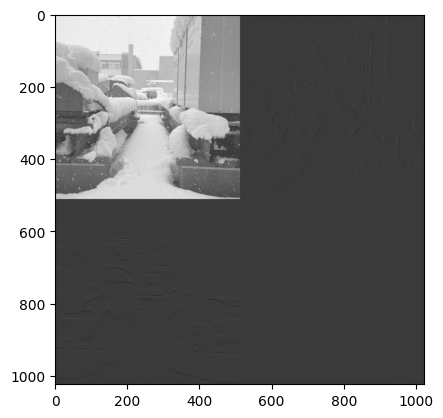

In [8]:
plt.imshow(compImg, cmap='gray')
# plt.imshow(compImg)
plt.show()